In [1]:
import pandas as pd
import numpy as np
import wave
from scipy.io import wavfile
import os
import librosa
import pydub
import ffmpeg
from librosa.feature import melspectrogram
import warnings
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image
from uuid import uuid4
import sklearn
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



In [2]:
# Import index dataframe that contains all information about data.  View data
index_df = pd.read_csv('xeno-canto_ca-nv_index.csv')
index_df.head()

,Unnamed: 0,country,duration_seconds,english_cname,file_id,file_name,file_url,genus,latitude,license,location,longitude,recordist,recordist_url,sonogram_url,species,type,remarks,full_name
0,0,United States,3,Abert's Towhee,17804,XC17804.mp3,https://www.xeno-canto.org/17804/download,Melozone,33.3117,http://creativecommons.org/licenses/by-nc-nd/2.5/,"Cibola National Wildlife Refuge, Cibola, Arizo...",-114.68912,Nathan Pieplow,https://www.xeno-canto.org/contributor/EKKJJJRDJY,https://www.xeno-canto.org/sounds/uploaded/EKK...,aberti,'seet' call,XC17804 © Nathan Pieplow // Cibola National Wi...,Abert's Towhee (Melozone aberti)
1,1,United States,4,Abert's Towhee,177367,XC177367.mp3,https://www.xeno-canto.org/177367/download,Melozone,34.2850,http://creativecommons.org/licenses/by-nc-sa/4.0/,"Bill Williams River NWR, Arizona, United States",-114.06900,Lauren Harter,https://www.xeno-canto.org/contributor/YQNGFTBRRT,https://www.xeno-canto.org/sounds/uploaded/YQN...,aberti,call,XC177367 © Lauren Harter // Bill Williams Rive...,Abert's Towhee (Melozone aberti dumeticola)
2,2,United States,4,Abert's Towhee,145505,XC145505.mp3,https://www.xeno-canto.org/145505/download,Melozone,34.2850,http://creativecommons.org/licenses/by-nc-sa/3.0/,"Bill Williams River NWR, Arizona, United States",-114.06900,Lauren Harter,https://www.xeno-canto.org/contributor/YQNGFTBRRT,https://www.xeno-canto.org/sounds/uploaded/YQN...,aberti,Squeal duet,XC145505 © Lauren Harter // Bill Williams Rive...,Abert's Towhee (Melozone aberti dumeticola)
3,3,United States,5,Abert's Towhee,228159,XC228159.mp3,https://www.xeno-canto.org/228159/download,Melozone,33.1188,http://creativecommons.org/licenses/by-nc-nd/4.0/,"Salton Sea, CA, United States",-115.79450,Peter Boesman,https://www.xeno-canto.org/contributor/OOECIWCSWV,https://www.xeno-canto.org/sounds/uploaded/OOE...,aberti,interaction duet,"XC228159 © Peter Boesman // Salton Sea, CA, Un...",Abert's Towhee (Melozone aberti)
4,4,United States,5,Abert's Towhee,51313,XC51313.mp3,https://www.xeno-canto.org/51313/download,Melozone,36.0628,http://creativecommons.org/licenses/by-nc-sa/3.0/,"Sunset Park, Las Vegas, Nevada, United States",-115.11280,Mike Nelson,https://www.xeno-canto.org/contributor/PWDLINYMKL,https://www.xeno-canto.org/sounds/uploaded/PWD...,aberti,call,"XC51313 © Mike Nelson // Sunset Park, Las Vega...",Abert's Towhee (Melozone aberti dumeticola)


In [7]:
# Identify unique number of birds
uniques = index_df['english_cname'].unique()
len(uniques)

91

In [ ]:
# Used this step to create list of folders corresponding to each of the bird names.  Only need to run once to create bird sub directories
for name in uniques:
    new_folders = name
    os.mkdir(new_folders)
    

In [9]:
# Count of samples for each type of bird
index_df.groupby(['english_cname']).count()

,Unnamed: 0,country,duration_seconds,file_id,file_name,file_url,genus,latitude,license,location,longitude,recordist,recordist_url,sonogram_url,species,type,remarks,full_name
english_cname,,,,,,,,,,,,,,,,,,
Abert's Towhee,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Acorn Woodpecker,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
American Bushtit,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
American Crow,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
American Dusky Flycatcher,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White-headed Woodpecker,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Wilson's Warbler,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Wrentit,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30


In [18]:
# Create function that transforms audio file into melspectogram
def get_sample(filename, bird, output_folder):
    wave_data, wave_rate = librosa.load(filename)
    wave_data, _ = librosa.effects.trim(wave_data)
    #only take 5s samples and add them to the dataframe
    song_sample = []
    sample_length = 5*wave_rate
    samples_from_file = []
    #The variable below is chosen mainly to create a 216x216 image
    N_mels=216
    for idx in range(0,len(wave_data),sample_length): 
        song_sample = wave_data[idx:idx+sample_length]
        if len(song_sample)>=sample_length:
            mel = melspectrogram(song_sample, n_mels=N_mels)
            db = librosa.power_to_db(mel)
            normalised_db = sklearn.preprocessing.minmax_scale(db)
            filename = str(uuid4())+".tif"
            db_array = (np.asarray(normalised_db)*255).astype(np.uint8)
            db_image =  Image.fromarray(np.array([db_array, db_array, db_array]).T)
            db_image.save("{}{}".format(output_folder,filename))
            
            samples_from_file.append({"song_sample":"{}{}".format(output_folder,filename),
                                            "bird":bird})
    return samples_from_file

In [20]:
warnings.filterwarnings("ignore")
samples_df = pd.DataFrame(columns=["song_sample","bird"])

#We limit the number of audio files being sampled to 1000 in this notebook to save time
#on top of having limited the number of bird species previously
sample_limit = 3000
sample_list = []

output_folder = "/Users/Pete/Desktop/bird_calls_thunder_struck_duck/Peter_S/melspectrogram_dataset/"
os.mkdir(output_folder)
with tqdm(total=sample_limit) as pbar:
    for idx, row in index_df[:sample_limit].iterrows():
        pbar.update(1)
        try:
            audio_file_path = "/Users/Pete/Desktop/Sounds/xeno-canto-ca-nv/"
            audio_file_path += row.english_cname
            
            if row.english_cname in most_represented_birds:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.file_name), row.english_cname, output_folder)
            else:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.file_name), "nocall", output_folder)
        except:
            raise
            print("{} is corrupted".format(audio_file_path))
            
samples_df = pd.DataFrame(sample_list)

 91%|██████████████████████████████████████████████████████████████████████▉       | 2730/3000 [50:43<05:01,  1.11s/it]


In [24]:
# Used for saving reference library
# print(samples_df)
# samples_df.to_csv('spectrograph_samples.csv')

                                             song_sample                  bird
0      /Users/Pete/Desktop/bird_calls_thunder_struck_...        Abert's Towhee
1      /Users/Pete/Desktop/bird_calls_thunder_struck_...        Abert's Towhee
2      /Users/Pete/Desktop/bird_calls_thunder_struck_...        Abert's Towhee
3      /Users/Pete/Desktop/bird_calls_thunder_struck_...        Abert's Towhee
4      /Users/Pete/Desktop/bird_calls_thunder_struck_...        Abert's Towhee
...                                                  ...                   ...
13540  /Users/Pete/Desktop/bird_calls_thunder_struck_...  Yellow-breasted Chat
13541  /Users/Pete/Desktop/bird_calls_thunder_struck_...  Yellow-breasted Chat
13542  /Users/Pete/Desktop/bird_calls_thunder_struck_...  Yellow-breasted Chat
13543  /Users/Pete/Desktop/bird_calls_thunder_struck_...  Yellow-breasted Chat
13544  /Users/Pete/Desktop/bird_calls_thunder_struck_...  Yellow-breasted Chat

[13545 rows x 2 columns]


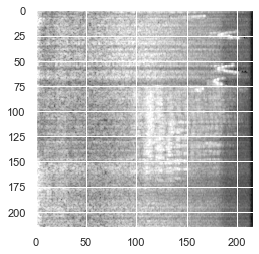

In [25]:
# demo_img = Image.open(samples_df.iloc[0].song_sample)
# plt.imshow(demo_img)
# plt.show()

In [14]:
data_df = pd.read_csv("spectrograph_samples.csv") 
del data_df['Unnamed: 0']
data_df.head()

,song_sample,bird
0,/Users/Pete/Desktop/bird_calls_thunder_struck_...,Abert's Towhee
1,/Users/Pete/Desktop/bird_calls_thunder_struck_...,Abert's Towhee
2,/Users/Pete/Desktop/bird_calls_thunder_struck_...,Abert's Towhee
3,/Users/Pete/Desktop/bird_calls_thunder_struck_...,Abert's Towhee
4,/Users/Pete/Desktop/bird_calls_thunder_struck_...,Abert's Towhee


In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_df, stratify=data_df['bird'], test_size=0.2)

In [19]:
# Create model and layers
classes_to_predict = sorted(data_df.bird.unique())
input_shape = (216,216, 3)
effnet_layers = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)

for layer in effnet_layers.layers:
    layer.trainable = True

dropout_dense_layer = 0.3

model = Sequential()
model.add(effnet_layers)
    
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(len(classes_to_predict), activation="softmax"))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327680    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 91)               

In [21]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [22]:
class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, data_df.bird.values)
class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

In [24]:
training_batch_size = 32
validation_batch_size = 32
target_size = (216,216)

train_datagen = ImageDataGenerator(
    rescale=1. / 255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    x_col='song_sample',
    y_col='bird',
    directory='/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='categorical')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = test,
    x_col='song_sample',
    y_col='bird',
    directory='/',
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size,
    class_mode='categorical')

Found 10836 validated image filenames belonging to 91 classes.
Found 2709 validated image filenames belonging to 91 classes.


In [25]:
history = model.fit(train_generator,
          epochs = 20, 
          validation_data=validation_generator,
          callbacks=callbacks)

Epoch 1/20
339/339 [==============================] - 1542s 5s/step - loss: 4.5206 - val_loss: 4.4577
Epoch 2/20
339/339 [==============================] - 1534s 5s/step - loss: 4.2358 - val_loss: 4.1912
Epoch 3/20
339/339 [==============================] - 1546s 5s/step - loss: 3.6876 - val_loss: 3.4383
Epoch 4/20
339/339 [==============================] - 1547s 5s/step - loss: 3.2065 - val_loss: 3.2969
Epoch 5/20
339/339 [==============================] - 1548s 5s/step - loss: 2.8035 - val_loss: 2.7643
Epoch 6/20
339/339 [==============================] - 1549s 5s/step - loss: 2.4449 - val_loss: 2.6830
Epoch 7/20
339/339 [==============================] - 1549s 5s/step - loss: 2.0782 - val_loss: 2.5139
Epoch 8/20
339/339 [==============================] - 1554s 5s/step - loss: 1.7806 - val_loss: 2.7069
Epoch 9/20
339/339 [==============================] - ETA: 0s - loss: 1.5180
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
339/339 [==================

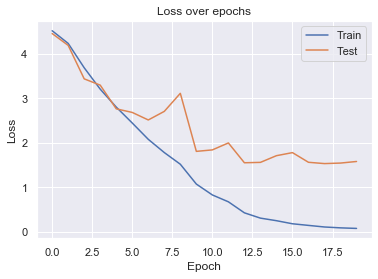

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [36]:
preds = model.predict_generator(validation_generator)
validation_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds[:32], validation_generator.__getitem__(0)[1]):
    validation_df = validation_df.append({"prediction":classes_to_predict[np.argmax(pred)], 
                                       "groundtruth":classes_to_predict[np.argmax(groundtruth)], 
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)
validation_df

,prediction,groundtruth,correct_prediction
0,American Crow,American Crow,True
1,Grey Vireo,Black-chinned Sparrow,False
2,Long-eared Owl,Anna's Hummingbird,False
3,Pacific Wren,Pacific Wren,True
4,Abert's Towhee,Black Phoebe,False
5,Steller's Jay,Acorn Woodpecker,False
6,House Finch,Pygmy Nuthatch,False
7,Lazuli Bunting,Lazuli Bunting,True
8,Swainson's Thrush,Swainson's Thrush,True
9,Northern Flicker,Northern Flicker,True


In [31]:
model.load_weights("best_model.h5")

In [41]:
validation_batch_size_full = 2709
target_size = (216,216)

train_datagen_full = ImageDataGenerator(
    rescale=1. / 255
)

validation_datagen_full = ImageDataGenerator(rescale=1. / 255)
validation_generator_full = validation_datagen_full.flow_from_dataframe(
    dataframe = test,
    x_col='song_sample',
    y_col='bird',
    directory='/',
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size_full,
    class_mode='categorical')

Found 2709 validated image filenames belonging to 91 classes.


In [43]:
# Run through predictions on entire test set and print results
preds = model.predict_generator(validation_generator_full)
validation_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds[:2709], validation_generator_full.__getitem__(0)[1]):
    validation_df = validation_df.append({"prediction":classes_to_predict[np.argmax(pred)], 
                                       "groundtruth":classes_to_predict[np.argmax(groundtruth)], 
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)
validation_df

,prediction,groundtruth,correct_prediction
0,American Crow,American Crow,True
1,Grey Vireo,Black-chinned Sparrow,False
2,Long-eared Owl,Anna's Hummingbird,False
3,Pacific Wren,Pacific Wren,True
4,Abert's Towhee,Black Phoebe,False
...,...,...,...
2704,Thick-billed Fox Sparrow,Green-tailed Towhee,False
2705,Northern Mockingbird,Bell's Vireo,False
2706,Long-eared Owl,Long-eared Owl,True
2707,Western Wood Pewee,Black-chinned Sparrow,False


In [44]:
validation_df.to_csv('validation_results.csv')

In [45]:
validation_df.groupby(['correct_prediction']).count()

,prediction,groundtruth
correct_prediction,,
False,905,905
True,1804,1804
